<a href="https://colab.research.google.com/github/sooonsyk/ESAA-22-2/blob/main/W15_HW_fri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4. 위성 이미지 분류

##4-1 텐서플로 데이터셋 로드

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt

# Tensorflow Datasets 활용
import tensorflow_datasets as tfds

In [2]:
#EuroSAT  위성 사진 데이터셋 로드

DATA_DIR = "dataset/"   

(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                        shuffle_files=True, 
                                        as_supervised=True,
                                        with_info=True,
                                        data_dir=DATA_DIR)
print(train_ds)
print(valid_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/2.0.0.incomplete4HPGR2/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


    - load 함수가 (훈련셋, 검증셋), 메타정보' 순으로 정리해 반환

In [3]:
# 메타데이터 확인
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

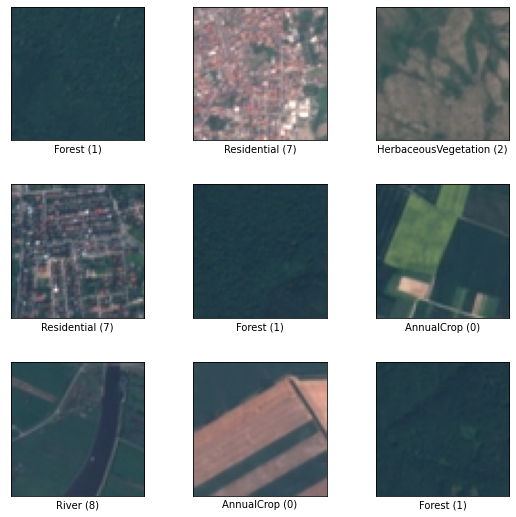

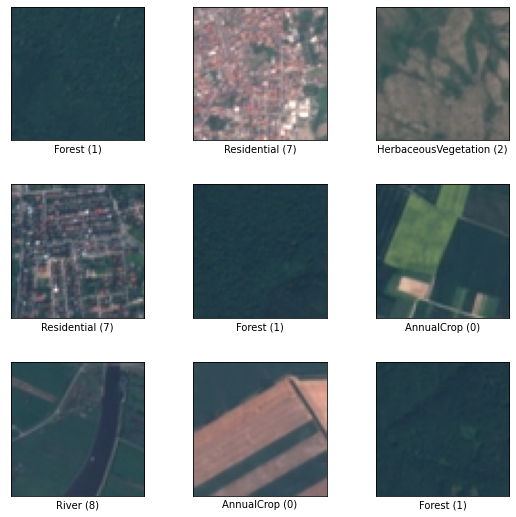

In [4]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

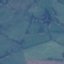
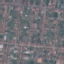
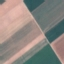
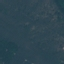
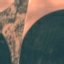
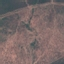
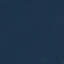
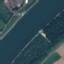
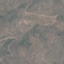
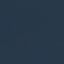

In [5]:
# as_dataframe 사용하여 샘플 출력
tfds.as_dataframe(valid_ds.take(10), info)

In [6]:
# 목표 클래스의 개수
NUM_CLASSES = info.features["label"].num_classes
print(NUM_CLASSES)

10


In [7]:
# 숫자 레이블을 활용하여 문자열 메타데이터로 변환
print(info.features["label"].int2str(6))

PermanentCrop


##4-2 데이터 전처리

- 텐서플로 연산은 float32 숫자 값ㅇ르 사용하기 때문에 cast 함수를 사용하여 자료형을 float32로 변환
- 입력 이미지가 0~~255 범위의 픽셀값을 가지므로 255로 나눠 정규화
- map 함수 : 사용자 정의 함수를 매핑하여 텐ㄴ서플로 데이터 셋에 적용하는 메소드로 전처리 과정에서 매우 유용, num_parallel_calls 옵션을 AUTOTUNE 으로 설정하면 텐서플로 병렬 연산 처리를 자동으로 최적화
- prefetch() 메소드는 모델이 훈련을 진행하는 동안 다음에 입력할 데이터를 불러와서 미리 전처리를 하도록 시스템 조율

In [8]:
# 데이터 전처리 파이프라인 
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화, float32 변환
    return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

#데이터 순서 랜덤하게 섞음 - 성능 높이기 위해 훈련 데이터셋에서 미니 배치 생성할 때 입력 순서에 무작위성 부여하는 개념
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

##4-2 모델 훈련 및 검증


In [9]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

model = build_model()

In [10]:
# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_data, 
                    validation_data=valid_data, 
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 196s 575ms/step - loss: 1.6378 - accuracy: 0.4364 - val_loss: 1.5604 - val_accuracy: 0.4811
Epoch 2/50
338/338 [==============================] - 194s 573ms/step - loss: 1.1809 - accuracy: 0.5905 - val_loss: 0.8207 - val_accuracy: 0.7374
Epoch 3/50
338/338 [==============================] - 194s 575ms/step - loss: 1.0035 - accuracy: 0.6523 - val_loss: 0.7233 - val_accuracy: 0.7543
Epoch 4/50
338/338 [==============================] - 188s 556ms/step - loss: 0.8934 - accuracy: 0.6848 - val_loss: 0.6368 - val_accuracy: 0.7841
Epoch 5/50
338/338 [==============================] - 192s 567ms/step - loss: 0.8032 - accuracy: 0.7187 - val_loss: 0.6132 - val_accuracy: 0.8052
Epoch 6/50
338/338 [==============================] - 197s 584ms/step - loss: 0.7343 - accuracy: 0.7442 - val_loss: 0.5147 - val_accuracy: 0.8315
Epoch 7/50
338/338 [==============================] - 192s 567ms/step - loss: 0.6699 - accuracy: 0.7683 - val_loss: 0.4931 -

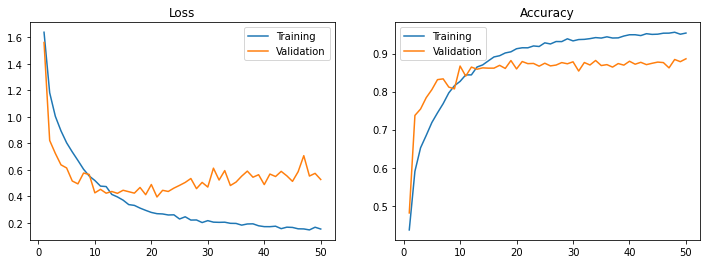

In [11]:
# 손실함수, 정확도 그래프 그리기 

def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

plot_loss_acc(history, 50)

- 모델은 10 epoch 까지는 빠른 속도로 훈련이 진행되면서 손실함수가 급격하게 감소하지만 그 이후로는 검증 셋에 대한 손실함수가 더 이상 줄어들지 않으면서 과대적합 경향 나타냄

##4-4 데이터 증강

- 과대적합 해소하는 기법인 배치 정규화, Dropout 등을 적용했음에도 불구하고 과대적합 발생
- 데이터 증강 data augmentation : 이미지 데이터에 여러 가지 변형을 주어서 훈련 데이터의 다양성 확보, 모델이 새로운 데이터에 대한 예측력 강화

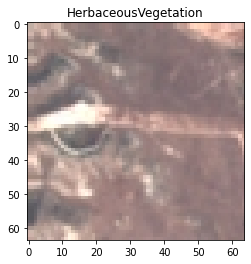

In [12]:
# 샘플 이미지
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [13]:
# 데이터 증강 전후를 비교하는 시각화 함수를 정의
def plot_augmentation(original, augmented):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].imshow(original)
    axes[0].set_title('Original')

    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')

    plt.show()

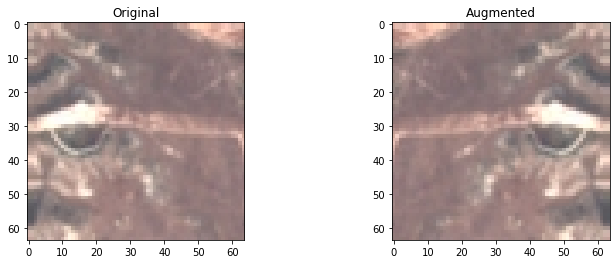

In [14]:
# 좌우 뒤집기 
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

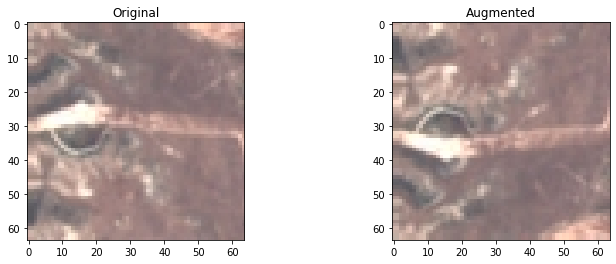

In [15]:
# 상하 뒤집기 
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

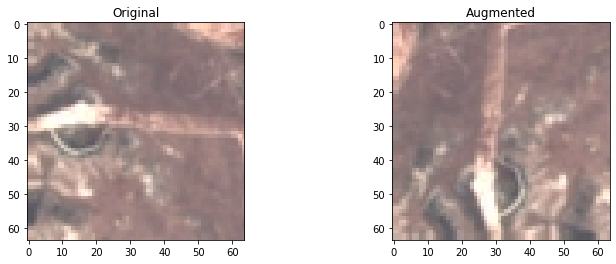

In [16]:
# 회전 - 90도
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

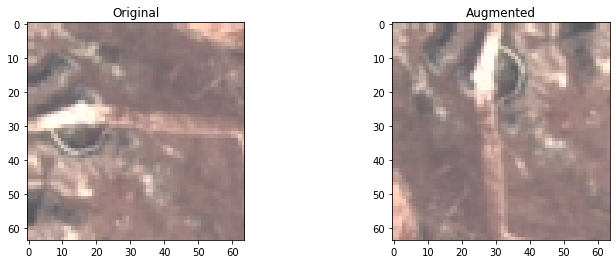

In [17]:
# transpose 
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

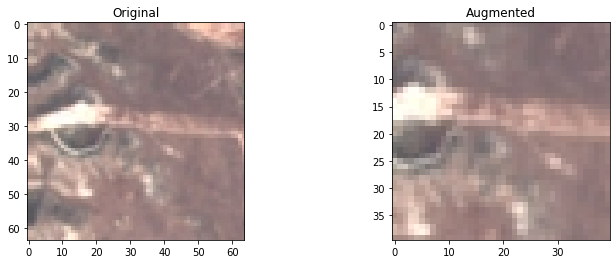

In [18]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

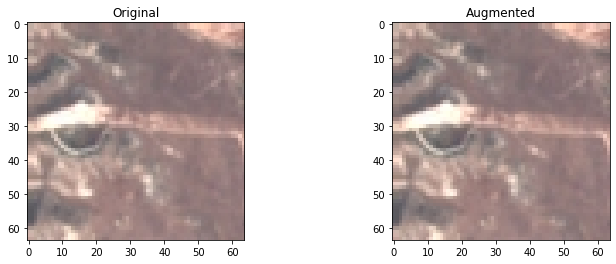

In [19]:
# 이미지 자르기 2 
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20) # 사이즈 키우기
crop2 = tf.image.random_crop(img, size=[64, 64, 3])
plot_augmentation(image, crop2)

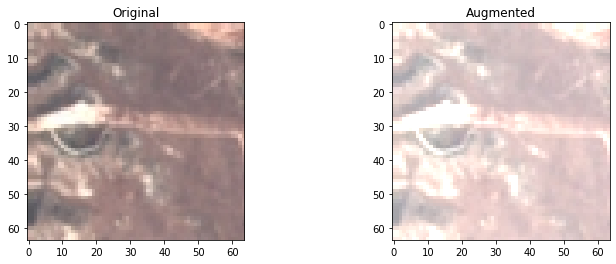

In [20]:
# 이미지 밝기 
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

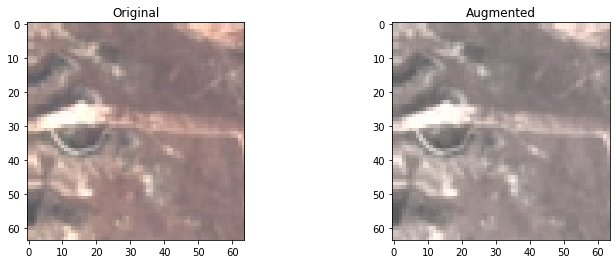

In [21]:
# 이미지 채도 
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

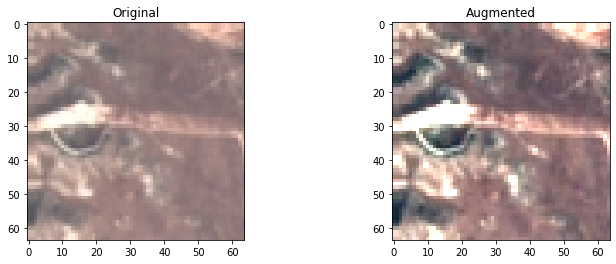

In [22]:
# 이미지 대비  
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

In [23]:
# 이미지 증강 전처리
def data_augmentation(image, label):

    #랜덤성 부여
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_flip_up_down(image) # 상하 반전    
    image = tf.image.random_brightness(image, max_delta=0.3) # 밝기 변화 
    image = tf.image.random_crop(image, size=[64, 64, 3])

    image = tf.cast(image, tf.float32) / 255.   # 0~1 정규화

    return image, label
#원본 데이터에 적용
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

#미니배치
train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE) 

print(train_aug)
print(valid_aug)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
# 모델 생성
aug_model = build_model()

# 모델 컴파일
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 훈련
aug_history = aug_model.fit(train_aug, 
                            validation_data=valid_aug, 
                            epochs=50)

Epoch 1/50
338/338 [==============================] - 197s 580ms/step - loss: 1.8658 - accuracy: 0.3217 - val_loss: 1.6750 - val_accuracy: 0.3880
Epoch 2/50
338/338 [==============================] - 186s 548ms/step - loss: 1.4938 - accuracy: 0.4402 - val_loss: 1.2040 - val_accuracy: 0.5661
Epoch 3/50
338/338 [==============================] - 190s 562ms/step - loss: 1.3896 - accuracy: 0.4878 - val_loss: 1.1652 - val_accuracy: 0.5857
Epoch 4/50
338/338 [==============================] - 190s 562ms/step - loss: 1.2588 - accuracy: 0.5449 - val_loss: 1.0128 - val_accuracy: 0.6430
Epoch 5/50
338/338 [==============================] - 188s 554ms/step - loss: 1.1917 - accuracy: 0.5679 - val_loss: 0.9761 - val_accuracy: 0.6424
Epoch 6/50
338/338 [==============================] - 191s 566ms/step - loss: 1.1390 - accuracy: 0.5872 - val_loss: 0.9655 - val_accuracy: 0.6715
Epoch 7/50
338/338 [==============================] - 191s 563ms/step - loss: 1.0660 - accuracy: 0.6161 - val_loss: 0.8737 -

In [ ]:
# 손실함수, 정확도 그래프 그리기 
plot_loss_acc(aug_history, 50)

- 손실함수 50 epoch 동안 계속 줄어들고 정확도 조금씩 우상향 하면서 개선 - 과대적합 상당히 해소됨

##4-5 ResNet 사전 학습 모델


- 사전에 방대한 이미지로 훈련을 받은 딥러닝 모델의 구조와 가중치를 그대로 가져오고, 모델의 끝단에 위치하는 Top 층에 위성 이미지를 분류할 수 있는 최종 분류기를 추가하는 방식으로 모델 구성 - 전이 학습


In [ ]:
# Pre-trained 모델을 사전 학습된 가중치와 함께 가져오기
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, #Top 층 제거하고 최종 분류기 대체해서 추가
                               weights='imagenet',
                               input_shape=[64, 64, 3])
, 
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

# 모델 구조 시각화
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')


In [ ]:
# Top 층에 Classifier 추가

def build_trainsfer_classifier():

    model = tf.keras.Sequential([

        # Pre-trained Base 
        pre_trained_base,
        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'), 
        tf.keras.layers.Dropout(0.3),  
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])

    return model

# 모델 구조
tc_model = build_trainsfer_classifier()    
tc_model.summary()

#5. 개/고양이 분류

- 이미지 파일 용량이 크거나 개수가 많아서 컴퓨터 메모리 또는 그래픽 카드 메모리가 부족한 상황 발생
- 이런 문제를 해결하려면 이미지 데이터 셋을 32, 64, 128등 배치 단위로 나눈 다음, 배치 한 개를 읽어와 딥러닝 모델에 주입하면 메모리 부담 없이 학습가능
- 전체 데이터셋을 전부 모델에 입력할 때까지 배치 단위로 읽어오고 주입하는 과정 반복

##5-1 분석 준비

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

In [ ]:
# 구글 드라이브 폴더 마운트 (코랩을 사용하는 경우)
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# 훈련 셋, 검증 셋 저장위치 지정
train_dir =  "/content/drive/MyDrive/training_set/training_set"
valid_dir = "/content/drive/MyDrive/test_set/test_set"
print(train_dir)
print(valid_dir)

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

In [ ]:
plot_loss_acc(history, 20)

- 훈련 초기부터 검증 셋에 대한 정확도 80% 넘음,사전 학습 모델인 ResNet 모델의 가중치를 그대로 사용하기 때문에 새로운 데이터가 입력되어도 이미지로부터 피처를 빠르게 추출

##5-2 모델 학습

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 미적용)
image_gen = ImageDataGenerator(rescale=(1/255.)) #정규화
image_gen

In [ ]:
# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen = image_gen.flow_from_directory(train_dir, 
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

valid_gen = image_gen.flow_from_directory(valid_dir,                                          
                                          batch_size=32, 
                                          target_size=(224, 224),   
                                          classes=['cats','dogs'], 
                                          class_mode = 'binary',
                                          seed=2020)

In [ ]:
# 샘플 이미지 출력
class_labels = ['cats', 'dogs']
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize=(16, 8))
for i in range(32):
    
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[labels[i].astype(np.int)])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Sequential API를 사용하여 샘플 모델 생성

def build_model():

    model = tf.keras.Sequential([

        # Convolution 층 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Classifier 출력층 
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.3),              
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    return model

model = build_model()

In [ ]:
# 모델 컴파일
model.compile(optimizer=tf.optimizers.Adam(lr=0.001), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history = model.fit(train_gen, validation_data=valid_gen, epochs=20)

In [ ]:
plot_loss_acc(history, 20)
#과대적합

###데이터 증강
- ImageDataGenerator 를 사용하면 다양한 데이터 증강 기법을 클래스 함수의 매개변수 속성으로 저장할 수 있어서 편리

In [ ]:
# 이미지 데이터 제너레이터 정의 (Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale=1/255., 
                                   horizontal_flip=True,
                                   rotation_range=35,                                
                                   zoom_range=0.2)

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리 
train_gen_aug = image_gen_aug.flow_from_directory(train_dir, 
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,  
                                                  batch_size=32, 
                                                  target_size=(224,224),   
                                                  classes=['cats','dogs'], 
                                                  class_mode = 'binary', 
                                                  seed=2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer=tf.optimizers.Adam(lr=0.001),  
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data=valid_gen_aug, epochs=40)

In [ ]:
# 손실함수, 정확도 그래프 그리기 - 과대적합 과소적합 거의 발생하지 않음
plot_loss_acc(history_aug, 40)